# 1. Introduction: Mushroom Classification
By Maya Stelzer and Maura Sweeney

CPSC 322, Fall 2025

## Dataset (mushrooms.csv)
- Size: 8124 instances
- Features: 22 categorical features in the original dataset
- Target: class (edible or poisonous)


# 2. Data Analysis

## About the datasets

Before cleaning: 8124 instances

After cleaning: 5644 instances

Label: class (e=edible, p=poisonous)

- cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
- cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
- cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
- bruises: bruises=t,no=f
- odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
- gill-attachment: attached=a,descending=d,free=f,notched=n
- gill-spacing: close=c,crowded=w,distant=d
- gill-size: broad=b,narrow=n
- gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
- stalk-shape: enlarging=e,tapering=t
- stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
- stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
- stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
- stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
- stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
- veil-type: partial=p,universal=u
- veil-color: brown=n,orange=o,white=w,yellow=y
- ring-number: none=n,one=o,two=t
- ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
- spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
- population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
- habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

## Relevant summary statistics
- 61.8% edible vs 38.2% poisonous

In [11]:
# some useful mysklearn package import statements and reloads
import importlib

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyDecisionTreeClassifier
from mysklearn.myclassifiers import MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

# random seed for reproducibility
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import csv

In [2]:
# Load the mushroom dataset
mushroom_table = MyPyTable()
mushroom_table.load_from_file('mushrooms.csv')

print(f"Dataset loaded: {len(mushroom_table.data)} instances")
print(f"Columns: {mushroom_table.column_names}")

Dataset loaded: 8124 instances
Columns: ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


In [18]:
# Clean the dataset
print("\n" + "="*80)
print("DATA CLEANING")
print("="*80)

# Check for missing values
total_rows = len(mushroom_table.data)
missing_counts = {}

for col_idx, col_name in enumerate(mushroom_table.column_names):
    missing_count = sum(1 for row in mushroom_table.data if row[col_idx] in ['?', '', None, 'NA', 'N/A'])
    if missing_count > 0:
        missing_counts[col_name] = missing_count
        print(f"{col_name}: {missing_count} missing values ({missing_count/total_rows*100:.2f}%)")

if not missing_counts:
    print("No missing values found")

# Remove rows with missing values if any exist
if missing_counts:
    original_count = len(mushroom_table.data)
    
    # Filter out rows with missing values
    cleaned_data = []
    for row in mushroom_table.data:
        has_missing = False
        for col_idx, value in enumerate(row):
            if value in ['?', '', None, 'NA', 'N/A']:
                has_missing = True
                break
        if not has_missing:
            cleaned_data.append(row)
    
    mushroom_table.data = cleaned_data
    removed_count = original_count - len(mushroom_table.data)
    print(f"Removed {removed_count} rows with missing values")
    print(f"Remaining instances: {len(mushroom_table.data)}")

# Check for duplicates
seen = set()
duplicates = 0
unique_data = []

for row in mushroom_table.data:
    row_tuple = tuple(row)
    if row_tuple not in seen:
        seen.add(row_tuple)
        unique_data.append(row)
    else:
        duplicates += 1

if duplicates > 0:
    print(f"Found {duplicates} duplicate rows")
    mushroom_table.data = unique_data
    print(f"Remaining instances: {len(mushroom_table.data)}")
else:
    print("No duplicate rows found")

print("\n" + "="*80)
print(f"FINAL CLEAN DATASET: {len(mushroom_table.data)} instances")
print("="*80)

# Save output file
MyPyTable.save_to_file(mushroom_table, "clean_mushrooms.csv")


DATA CLEANING
stalk-root: 2480 missing values (30.53%)
Removed 2480 rows with missing values
Remaining instances: 5644
No duplicate rows found

FINAL CLEAN DATASET: 5644 instances


In [4]:
# EDA

# class distribution
df = MyPyTable().load_from_file("clean_mushrooms.csv")

label_col = df.get_column("class")
class_counts = {}
for label in label_col:
    class_counts[label] = class_counts.get(label, 0) + 1

print(class_counts)

# frequency distributions of key features
odor_col = df.get_column("odor")
bruises_col = df.get_column("bruises")
gill_size_col = df.get_column("gill-size")
spore_color_col = df.get_column("spore-print-color")
habitat_col = df.get_column("habitat")
population_col = df.get_column("population")
cap_shape_col = df.get_column("cap-shape")

def get_counts(col):
    counts = {}
    for val in col:
        counts[val] = counts.get(val, 0) + 1
    return counts

odor_counts = get_counts(odor_col)
bruises_counts = get_counts(bruises_col)
gill_size_counts = get_counts(gill_size_col)
spore_color_counts = get_counts(spore_color_col)
habitat_counts = get_counts(habitat_col)
population_counts = get_counts(population_col)
cap_shape_counts = get_counts(cap_shape_col)

print("Odor Counts:", odor_counts)
print("Bruises Counts:", bruises_counts)
print("Gill Size Counts:", gill_size_counts)
print("Spore Print Color Counts:", spore_color_counts)
print("Habitat Counts:", habitat_counts)
print("Population Counts:", population_counts)
print("Cap shape Counts:", cap_shape_counts)

{'p': 2156, 'e': 3488}
Odor Counts: {'p': 256, 'a': 400, 'l': 400, 'n': 2776, 'f': 1584, 'c': 192, 'm': 36}
Bruises Counts: {'t': 3184, 'f': 2460}
Gill Size Counts: {'n': 704, 'b': 4940}
Spore Print Color Counts: {'k': 1872, 'n': 1920, 'u': 48, 'h': 1584, 'r': 72, 'w': 148}
Habitat Counts: {'u': 368, 'g': 1860, 'm': 292, 'd': 2492, 'p': 568, 'l': 64}
Population Counts: {'s': 1104, 'n': 256, 'a': 384, 'v': 2160, 'y': 1688, 'c': 52}
Cap shape Counts: {'x': 2840, 'b': 300, 's': 32, 'f': 2432, 'k': 36, 'c': 4}


## Data visualizations

The 8 graphs below show the frequency distributions between the attributes: class, odor, bruises, gill size, spore print color, habitat, population, and cap shape.

The three graphs after the frequency graphs display the comparison between class and odor, gill size, and bruises. We can see odor has the strongest correlation as all of the different odors: almond, anise, creosote, fishy, foul, musty, none, pungent, and spicy, correlate to either edible or poisonous. Gill size and bruises don't have as strong of relationship to class but still favor edible or poisonous

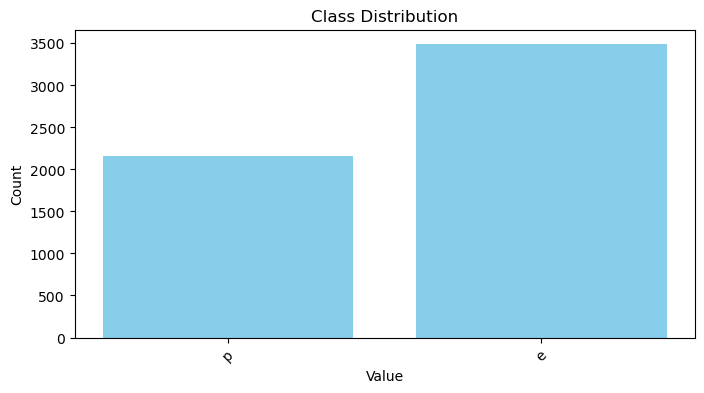

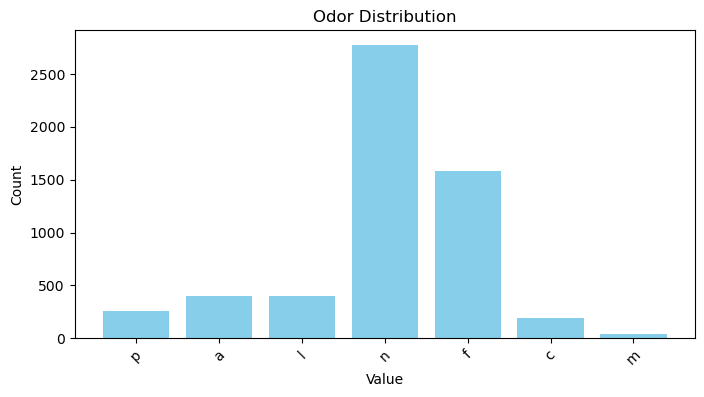

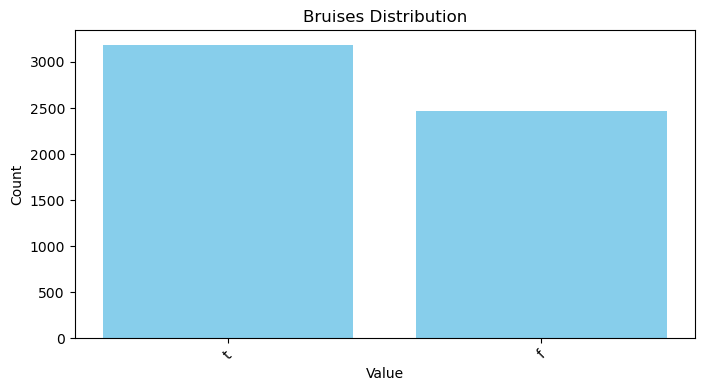

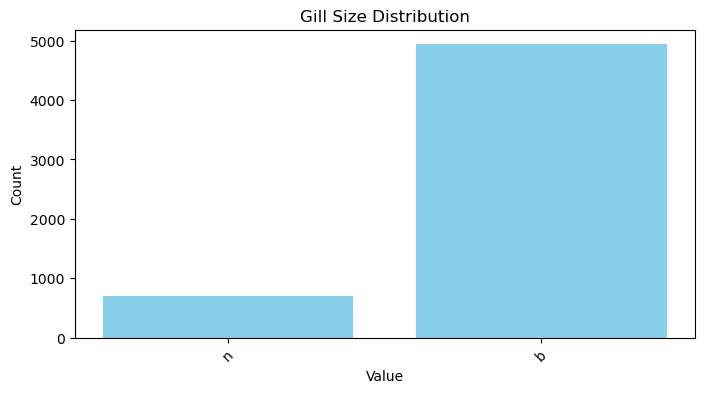

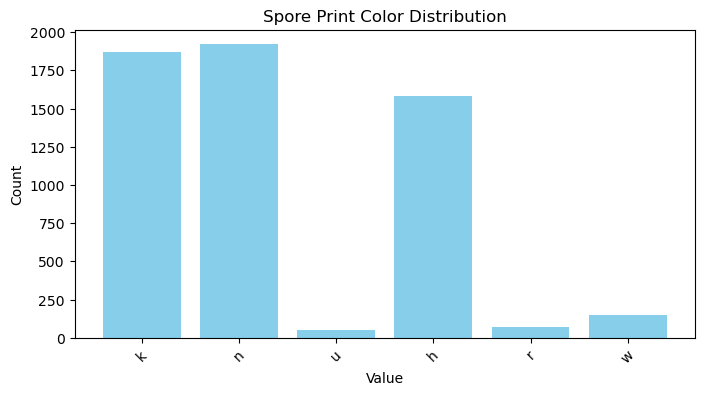

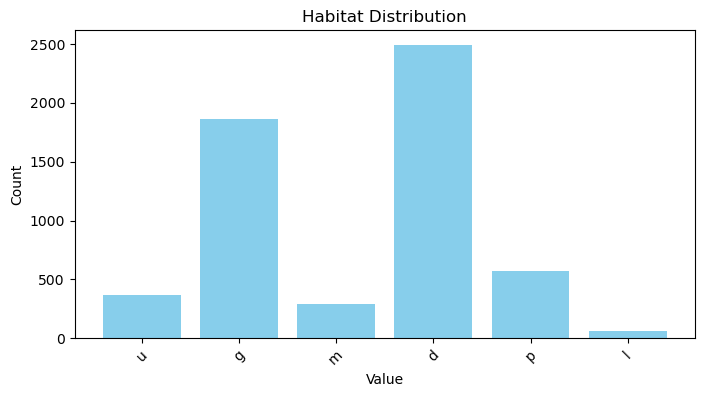

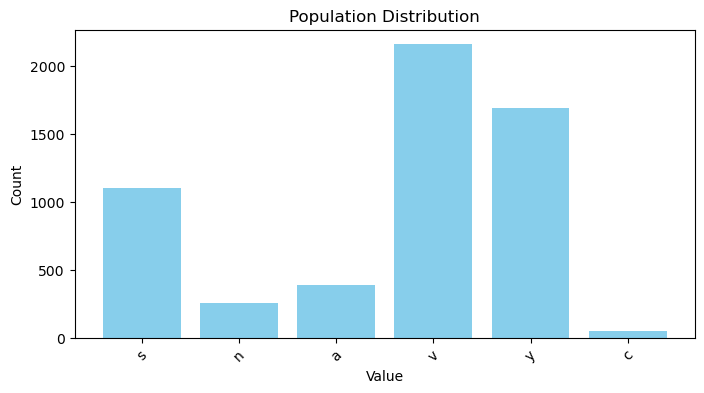

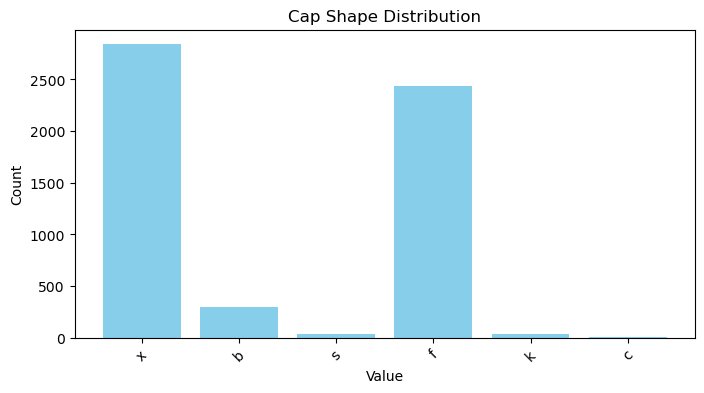

In [5]:
import matplotlib.pyplot as plt

def plot_counts(counts_dict, title, xlabel="Value", ylabel="Count"):
    plt.figure(figsize=(8,4))
    plt.bar(counts_dict.keys(), counts_dict.values(), color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()

# Plot class distribution
plot_counts(class_counts, "Class Distribution")

# Plot other features
plot_counts(odor_counts, "Odor Distribution")
plot_counts(bruises_counts, "Bruises Distribution")
plot_counts(gill_size_counts, "Gill Size Distribution")
plot_counts(spore_color_counts, "Spore Print Color Distribution")
plot_counts(habitat_counts, "Habitat Distribution")
plot_counts(population_counts, "Population Distribution")
plot_counts(cap_shape_counts, "Cap Shape Distribution")


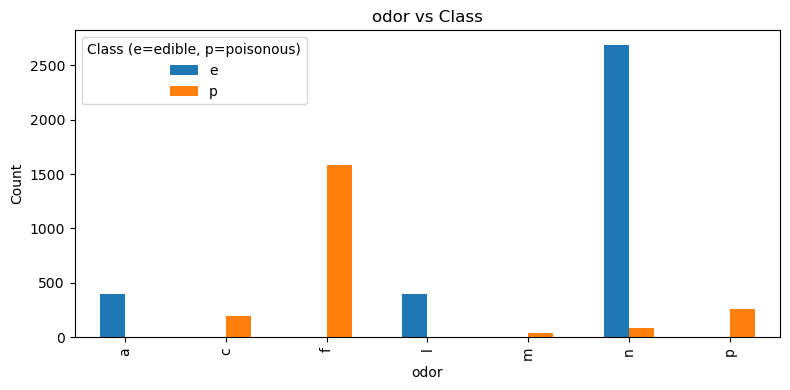

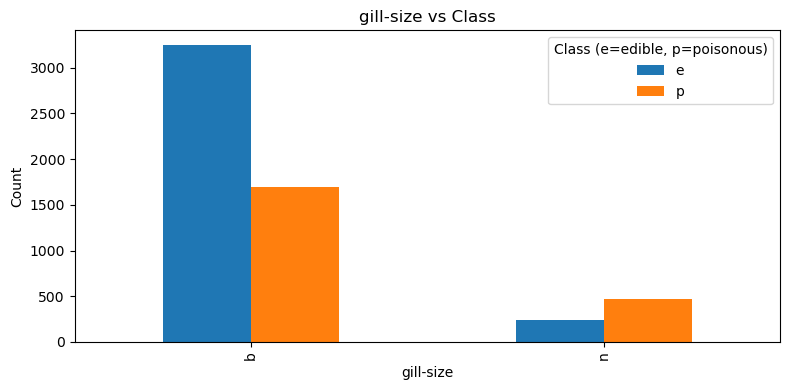

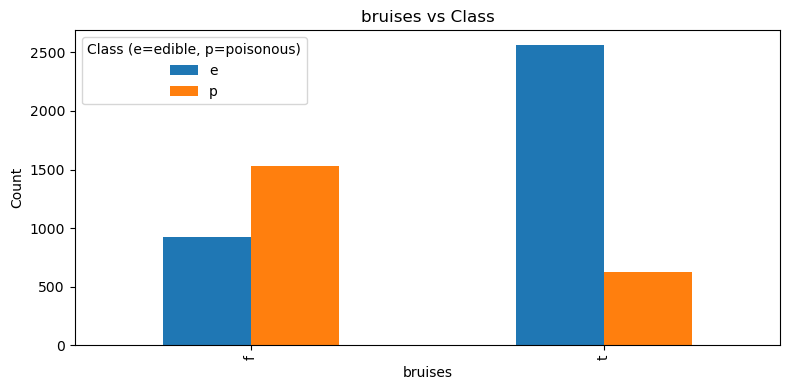

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("clean_mushrooms.csv")

def plot_class_comparison(feature):
    crosstab = pd.crosstab(df[feature], df["class"])

    crosstab.plot(kind="bar", figsize=(8,4))
    plt.title(f"{feature} vs Class")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title="Class (e=edible, p=poisonous)")
    plt.tight_layout()
    plt.show()


plot_class_comparison("odor")
plot_class_comparison("gill-size")
plot_class_comparison("bruises")


In [6]:
# Helper function to run 10-fold cross-validation and display results
def evaluate_feature_subset(X, y, subset_name, feature_names):
    """Run 10-fold cross-validation and compute metrics for feature subset."""
    print("\n" + "="*80)
    print(f"{subset_name}")
    print(f"Features: {', '.join(feature_names)}")
    print("="*80)
    
    # Perform 10-fold cross-validation
    folds = myevaluation.kfold_split(X, n_splits=10, random_state=42, shuffle=True)
    
    all_y_true = []
    all_y_pred = []
    
    for train_indices, test_indices in folds:
        # Split data
        X_train = [X[i] for i in train_indices]
        y_train = [y[i] for i in train_indices]
        X_test = [X[i] for i in test_indices]
        y_test = [y[i] for i in test_indices]
        
        # Train and predict
        tree = MyDecisionTreeClassifier()
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
    
    # Compute metrics
    accuracy = myevaluation.accuracy_score(all_y_true, all_y_pred)
    error_rate = 1 - accuracy
    
   
    labels = sorted(list(set(all_y_true)))
    print(f"Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Error Rate:  {error_rate:.4f} ({error_rate*100:.2f}%)")
    
    # Per class metrics
    print(f"\nPer-Class Performance Metrics:")
    print(f"{'Class':<15} {'Precision':>12} {'Recall':>12} {'F1-Score':>12}")
    print("-" * 53)
    
    for label in labels:
        precision = myevaluation.binary_precision_score(all_y_true, all_y_pred, label)
        recall = myevaluation.binary_recall_score(all_y_true, all_y_pred, label)
        f1 = myevaluation.binary_f1_score(all_y_true, all_y_pred, label)
        print(f"{label:<15} {precision:>12.4f} {recall:>12.4f} {f1:>12.4f}")
    
    # Confusion
    conf_matrix = myevaluation.confusion_matrix(all_y_true, all_y_pred, labels)
    myutils.print_confusion_matrix(conf_matrix, labels, "\nConfusion Matrix")
    
    return accuracy, tree

# 3. Classification Results

## Classifier 1: Decision Tree w/ Pruning


### Decision Rules from Best Model

Training the best feature subset on the entire dataset to extract decision rules.

In [10]:
# Train best model on entire dataset
print("\n" + "="*80)
print("DECISION RULES FROM BEST MODEL")
print("="*80)
print(f"\nFeatures used: {best_result['features']}\n")

# Get feature indices for best subset
best_feature_indices = [mushroom_table.column_names.index(f) for f in best_result['features']]
X_best = [[row[idx] for idx in best_feature_indices] for row in mushroom_table.data]

# Train on entire dataset
final_tree = MyDecisionTreeClassifier()
final_tree.fit(X_best, y)

# Print decision rules
final_tree.print_decision_rules(attribute_names=best_result['features'], class_name='label')


DECISION RULES FROM BEST MODEL

Features used: ['odor', 'cap-color', 'stalk-color-below-ring', 'population', 'habitat']

IF odor == a THEN label = e
IF odor == c THEN label = p
IF odor == f THEN label = p
IF odor == l THEN label = e
IF odor == m THEN label = p
IF odor == n AND cap-color == b THEN label = p
IF odor == n AND cap-color == c THEN label = e
IF odor == n AND cap-color == e THEN label = e
IF odor == n AND cap-color == g THEN label = e
IF odor == n AND cap-color == n THEN label = e
IF odor == n AND cap-color == p AND habitat == d THEN label = p
IF odor == n AND cap-color == p AND habitat == g THEN label = p
IF odor == n AND cap-color == p AND habitat == l THEN label = p
IF odor == n AND cap-color == p AND habitat == m THEN label = p
IF odor == n AND cap-color == p AND habitat == p THEN label = e
IF odor == n AND cap-color == p AND habitat == u THEN label = p
IF odor == n AND cap-color == w AND population == a THEN label = e
IF odor == n AND cap-color == w AND population == c 

### Analysis and Pruning Discussion

- Rules with very few instances are not very applicable and can be pruned and replaced with majority class
- Multiple rules leading to the same class with similar conditions can be merged them
- For each internal node, if removing that subtree and replacing with majority class doesn't affect accuracy on validation set it can be pruned
- Leaf nodes with low confidence can be replace with parent's majority or mark as uncertain
- The most important features can be kept and rules that split on less important features in the tree can be pruned
- Pruning decisions should be based on: validation set results, instance counts at each node, classification confidence for leaf nodes


### Conclusions
- The odor feature alone provides strong and reliable baseline performance.
- Adding more features beyond odor may provide marginal improvements, but risks overfitting on the training data.
- The subset with the highest accuracy balances predictive power with model simplicity.

- Pruning the decision tree would:
   - Reduce overfitting
   - Improve generalization 
   - Create more interpretable rules
   - Keep high accuracy with reduced complexity

In [12]:
def report_change(original_accuracy, modified_accuracy, 
                  original_leaves, modified_leaves,
                  original_stats, modified_stats):
    """
    Report the improvement/difference before and after optimization.
    
    Args:
        original_accuracy: Accuracy before optimization
        modified_accuracy: Accuracy after optimization
        original_leaves: Number of leaves before optimization
        modified_leaves: Number of leaves after optimization
        original_stats: Statistics dict for original tree
        modified_stats: Statistics dict for modified tree
    """
    
    # Tree complexity comparison
    print("\nTREE COMPLEXITY")
    print("-" * 80)
    print(f"{'Metric':<30} {'Original':>15} {'Modified':>15} {'Change':>15}")
    print("-" * 80)
    
    leaves_reduction = original_leaves - modified_leaves
    leaves_pct = (leaves_reduction / original_leaves * 100) if original_leaves > 0 else 0
    print(f"{'Number of Leaf Nodes':<30} {original_leaves:>15} {modified_leaves:>15} "
          f"{-leaves_reduction:>15} ({-leaves_pct:.1f}%)")
    
    orig_avg = sum(original_stats['counts']) / len(original_stats['counts'])
    modified_avg = sum(modified_stats['counts']) / len(modified_stats['counts'])
    print(f"{'Avg Instances per Leaf':<30} {orig_avg:>15.1f} {modified_avg:>15.1f} "
          f"{modified_avg - orig_avg:>15.1f}")

    # Performance comparison
    print("\nPREDICTIVE PERFORMANCE")
    print("-" * 80)
    print(f"{'Metric':<30} {'Original':>15} {'Modified':>15} {'Change':>15}")
    print("-" * 80)
    
    orig_error = 1 - original_accuracy
    modified_error = 1 - modified_accuracy
    accuracy_diff = modified_accuracy - original_accuracy
    error_diff = modified_error - orig_error
    
    print(f"{'Accuracy':<30} {original_accuracy:>14.4f} {modified_accuracy:>14.4f} "
          f"{accuracy_diff:>+14.4f}")
    print(f"{'Error Rate':<30} {orig_error:>14.4f} {modified_error:>14.4f} "
          f"{error_diff:>+14.4f}")
    
    print("="*80)

### Pruning by Removing Rules with Few Instances

Implementing pruning to remove rules with very few training instances and replace them with majority class predictions.

In [13]:
import copy

def prune_tree(tree, min_instances=10):
    """Prune decision tree by removing leaves with few instances.
    
    Args:
        tree: The decision tree to prune (nested list format)
        min_instances: Minimum number of instances required to keep a leaf
        
    Returns:
        Pruned tree
    """
    if tree[0] == "Leaf":
        # If it's a leaf, return as-is (pruning happens at parent level)
        return tree
    
    if tree[0] == "Attribute":
        # Process each value branch
        pruned_tree = ["Attribute", tree[1]]
        
        # Get all leaves from children to determine if should prune
        leaves = []
        for i in range(2, len(tree)):
            value_branch = tree[i]  # ["Value", value, subtree]
            if value_branch[0] == "Value":
                value = value_branch[1]
                subtree = value_branch[2]
                
                # Recursively prune subtree
                pruned_subtree = prune_tree(subtree, min_instances)
                
                # Get leaf information
                if pruned_subtree[0] == "Leaf":
                    leaves.append({
                        'label': pruned_subtree[1],
                        'count': pruned_subtree[2],
                        'parent_count': pruned_subtree[3]
                    })
                
                pruned_tree.append(["Value", value, pruned_subtree])
        
        # Check if all children are leaves with low instance counts
        if leaves and len(leaves) == len(tree) - 2:  # -2 for "Attribute" and attribute name
            total_instances = sum(leaf['count'] for leaf in leaves)
            
            # If instances below threshold, collapse to one leaf
            if total_instances < min_instances:
                # Find majority class of the leaves
                label_counts = {}
                for leaf in leaves:
                    label = leaf['label']
                    label_counts[label] = label_counts.get(label, 0) + leaf['count']
                
                majority_label = max(label_counts.items(), key=lambda x: x[1])[0]
                
                # Return collapsed leaf (use first leaf's parent_count)
                return ["Leaf", majority_label, total_instances, leaves[0]['parent_count']]
        
        return pruned_tree
    
    return tree


def count_leaves(tree):
    """Count the number of leaf nodes in a tree."""
    if tree[0] == "Leaf":
        return 1
    elif tree[0] == "Attribute":
        count = 0
        for i in range(2, len(tree)):
            value_branch = tree[i]
            if value_branch[0] == "Value":
                count += count_leaves(value_branch[2])
        return count
    return 0


def get_leaf_statistics(tree, stats=None):
    """Get statistics about leaf nodes."""
    if stats is None:
        stats = {'counts': [], 'labels': []}
    
    if tree[0] == "Leaf":
        stats['counts'].append(tree[2])
        stats['labels'].append(tree[1])
    elif tree[0] == "Attribute":
        for i in range(2, len(tree)):
            value_branch = tree[i]
            if value_branch[0] == "Value":
                get_leaf_statistics(value_branch[2], stats)
    
    return stats

original_tree = copy.deepcopy(best_result['tree'].tree)
original_leaves = count_leaves(original_tree)
original_stats = get_leaf_statistics(original_tree)

# Apply pruning with min_instances threshold
MIN_INSTANCES = 15
print(f"\nPruning with min_instances = {MIN_INSTANCES}")
pruned_tree_obj = copy.deepcopy(best_result['tree'])
pruned_tree_obj.tree = prune_tree(original_tree, min_instances=MIN_INSTANCES)
pruned_leaves = count_leaves(pruned_tree_obj.tree)
pruned_stats = get_leaf_statistics(pruned_tree_obj.tree)

# Evaluate pruned tree
print(f"\n{'='*80}")
print("PRUNED TREE EVALUATION")
print(f"{'='*80}")

# Evaluate on same data using cross-validation
folds = myevaluation.kfold_split(X_best, n_splits=10, random_state=42, shuffle=True)

all_y_true = []
all_y_pred = []

for train_indices, test_indices in folds:
    X_train_fold = [X_best[i] for i in train_indices]
    y_train_fold = [y[i] for i in train_indices]
    X_test_fold = [X_best[i] for i in test_indices]
    y_test_fold = [y[i] for i in test_indices]
    
    # Train and prune
    tree = MyDecisionTreeClassifier()
    tree.fit(X_train_fold, y_train_fold)
    tree.tree = prune_tree(tree.tree, min_instances=MIN_INSTANCES)
    
    # Predict
    y_pred = tree.predict(X_test_fold)
    
    all_y_true.extend(y_test_fold)
    all_y_pred.extend(y_pred)

# Compute metrics
pruned_accuracy = myevaluation.accuracy_score(all_y_true, all_y_pred)

# Call the improvement report function
report_change(
    best_result['accuracy'], 
    pruned_accuracy,
    original_leaves,
    pruned_leaves,
    original_stats,
    pruned_stats
)

# Print pruned decision rules
print(f"\n{'='*80}")
print("NEW DECISION RULES")
print(f"{'='*80}\n")
pruned_tree_obj.print_decision_rules(attribute_names=best_result['features'], class_name='class')


Pruning with min_instances = 15

PRUNED TREE EVALUATION

TREE COMPLEXITY
--------------------------------------------------------------------------------
Metric                                Original        Modified          Change
--------------------------------------------------------------------------------
Number of Leaf Nodes                        24              24               0 (-0.0%)
Avg Instances per Leaf                   211.7           211.7             0.0

PREDICTIVE PERFORMANCE
--------------------------------------------------------------------------------
Metric                                Original        Modified          Change
--------------------------------------------------------------------------------
Accuracy                               1.0000         1.0000        +0.0000
Error Rate                             0.0000         0.0000        +0.0000

NEW DECISION RULES

IF odor == a THEN class = e
IF odor == c THEN class = p
IF odor == f THEN class =

### Rule Merging: Combining Similar Rules with Same Outcome

Implementing rule merging to simplify the tree by combining multiple branches that lead to the same classification.

In [14]:
def merge_similar_rules(tree, merge_threshold=0.8):
    """
    Merge rules that lead to the same class with similar conditions.
    
    If a majority (>= merge_threshold) of branches from an attribute node lead to the same class,
    collapse that node to a single leaf with that class.
    
    Args:
        tree: The decision tree to simplify (nested list format)
        merge_threshold: Fraction of branches that must agree (0.0 to 1.0)
                        Default 0.8 means 80% of branches must lead to same class
    
    Returns:
        Simplified tree with merged rules
    """
    if tree[0] == "Leaf":
        return tree
    
    if tree[0] == "Attribute":
        # First, recursively process all children
        merged_tree = ["Attribute", tree[1]]
        child_leaves = []
        
        for i in range(2, len(tree)):
            value_branch = tree[i]
            if value_branch[0] == "Value":
                value = value_branch[1]
                subtree = value_branch[2]
                
                # Recursively merge the subtree
                merged_subtree = merge_similar_rules(subtree, merge_threshold)
                merged_tree.append(["Value", value, merged_subtree])
                
                # Collect leaf information
                if merged_subtree[0] == "Leaf":
                    child_leaves.append({
                        'label': merged_subtree[1],
                        'count': merged_subtree[2],
                        'parent_count': merged_subtree[3]
                    })
        
        # Check if we can merge based on class agreement
        if child_leaves and len(child_leaves) == len(tree) - 2:  # All children are leaves
            # Count instances by label
            label_counts = {}
            total_instances = 0
            
            for leaf in child_leaves:
                label = leaf['label']
                count = leaf['count']
                label_counts[label] = label_counts.get(label, 0) + count
                total_instances += count
            
            # Find the majority class
            if label_counts:
                majority_label = max(label_counts.items(), key=lambda x: x[1])[0]
                majority_count = label_counts[majority_label]
                
                # Check if majority exceeds threshold
                if total_instances > 0:
                    majority_fraction = majority_count / total_instances
                    
                    if majority_fraction >= merge_threshold:
                        # Merge into a single leaf
                        return ["Leaf", majority_label, total_instances, child_leaves[0]['parent_count']]
        
        return merged_tree
    
    return tree


def count_rules(tree, path=[]):
    """Count the number of decision rules (leaf nodes) in a tree."""
    if tree[0] == "Leaf":
        return 1
    elif tree[0] == "Attribute":
        total = 0
        for i in range(2, len(tree)):
            value_branch = tree[i]
            if value_branch[0] == "Value":
                total += count_rules(value_branch[2])
        return total
    return 0

original_tree_copy = copy.deepcopy(best_result['tree'].tree)

MERGE_THRESHOLD = 0.8
print(f"\nMerge threshold: {MERGE_THRESHOLD*100:.0f}% (branches must agree this much to merge)")

# Create merged tree
merged_tree_obj = copy.deepcopy(best_result['tree'])
merged_tree_obj.tree = merge_similar_rules(original_tree_copy, merge_threshold=MERGE_THRESHOLD)

# Count rules before and after
original_rules = count_rules(original_tree_copy)
merged_rules = count_rules(merged_tree_obj.tree)
merged_leaves = count_leaves(merged_tree_obj.tree)
merged_stats = get_leaf_statistics(merged_tree_obj.tree)

print(f"\nOriginal Tree:")
print(f"  Decision rules: {original_rules}")
print(f"  Leaf nodes: {original_leaves}")

print(f"\nMerged Tree:")
print(f"  Decision rules: {merged_rules} (reduced by {original_rules - merged_rules})")
print(f"  Leaf nodes: {merged_leaves} (reduced by {original_leaves - merged_leaves})")
if merged_stats['counts']:
    print(f"  Avg instances per leaf: {sum(merged_stats['counts'])/len(merged_stats['counts']):.1f}")

# Evaluate merged tree
print(f"\n{'='*80}")
print("MERGED TREE EVALUATION")
print(f"{'='*80}")

folds = myevaluation.kfold_split(X_best, n_splits=10, random_state=42, shuffle=True)

all_y_true = []
all_y_pred = []

for train_indices, test_indices in folds:
    X_train_fold = [X_best[i] for i in train_indices]
    y_train_fold = [y[i] for i in train_indices]
    X_test_fold = [X_best[i] for i in test_indices]
    y_test_fold = [y[i] for i in test_indices]
    
    # Train and merge
    tree = MyDecisionTreeClassifier()
    tree.fit(X_train_fold, y_train_fold)
    tree.tree = merge_similar_rules(tree.tree, merge_threshold=MERGE_THRESHOLD)
    
    # Predict
    y_pred = tree.predict(X_test_fold)
    
    all_y_true.extend(y_test_fold)
    all_y_pred.extend(y_pred)

# Compute metrics
merged_accuracy = myevaluation.accuracy_score(all_y_true, all_y_pred)

# Use the reporting function
report_change(
    best_result['accuracy'], 
    merged_accuracy,
    original_leaves,
    merged_leaves,
    original_stats,
    merged_stats
)

# Print decision rules
print(f"\n{'='*80}")
print("NEW DECISION RULES")
print(f"{'='*80}\n")
final_tree.print_decision_rules(attribute_names=best_result['features'], class_name='class')


Merge threshold: 80% (branches must agree this much to merge)

Original Tree:
  Decision rules: 24
  Leaf nodes: 24

Merged Tree:
  Decision rules: 19 (reduced by 5)
  Leaf nodes: 19 (reduced by 5)
  Avg instances per leaf: 267.4

MERGED TREE EVALUATION

TREE COMPLEXITY
--------------------------------------------------------------------------------
Metric                                Original        Modified          Change
--------------------------------------------------------------------------------
Number of Leaf Nodes                        24              19              -5 (-20.8%)
Avg Instances per Leaf                   211.7           267.4            55.7

PREDICTIVE PERFORMANCE
--------------------------------------------------------------------------------
Metric                                Original        Modified          Change
--------------------------------------------------------------------------------
Accuracy                               1.0000         0

### Validation-Based Pruning

Testing each internal node by seeing if replacing the subtree with majority class doesn't hurt validation accuracy and pruning in this case.

In [15]:
def validation_prune_tree(tree, X_val, y_val, tree_obj):
    """
    Prune tree using validation set - replace subtrees with majority class if accuracy doesn't decrease.
    
    This is reduced error pruning: for each internal node, test if replacing it with a leaf
    improves or maintains validation accuracy.
    
    Args:
        tree: The decision tree structure (nested list)
        X_val: Validation features
        y_val: Validation labels
        tree_obj: The tree object (for prediction)
    
    Returns:
        Pruned tree
    """
    # Get baseline accuracy with current tree
    baseline_predictions = tree_obj.predict(X_val)
    baseline_accuracy = myevaluation.accuracy_score(y_val, baseline_predictions)
    
    # Try pruning this node
    pruned_tree = _validation_prune_recursive(tree, X_val, y_val, tree_obj, baseline_accuracy)
    
    return pruned_tree


def _validation_prune_recursive(tree, X_val, y_val, tree_obj, baseline_accuracy):
    """
    Recursively test pruning each subtree against validation set.
    """
    if tree[0] == "Leaf":
        return tree
    
    if tree[0] == "Attribute":
        # First, recursively prune children
        pruned_tree = ["Attribute", tree[1]]
        
        for i in range(2, len(tree)):
            value_branch = tree[i]
            if value_branch[0] == "Value":
                value = value_branch[1]
                subtree = value_branch[2]
                
                # Recursively prune the subtree
                pruned_subtree = _validation_prune_recursive(subtree, X_val, y_val, tree_obj, baseline_accuracy)
                pruned_tree.append(["Value", value, pruned_subtree])
        
        # Now test if we should prune this entire node
        # Collect all leaf labels under this node
        leaf_labels = []
        _collect_leaf_labels(pruned_tree, leaf_labels)
        
        if leaf_labels:
            # Find majority class
            label_counts = {}
            for label in leaf_labels:
                label_counts[label] = label_counts.get(label, 0) + 1
            majority_label = max(label_counts.items(), key=lambda x: x[1])[0]
            
            # Create a version with this node replaced by a leaf
            test_tree = ["Leaf", majority_label, sum(label_counts.values()), sum(label_counts.values())]
            
            # Test accuracy with pruned version
            original_tree = tree_obj.tree
            tree_obj.tree = test_tree
            pruned_predictions = tree_obj.predict(X_val)
            pruned_accuracy = myevaluation.accuracy_score(y_val, pruned_predictions)
            tree_obj.tree = original_tree  # Restore
            
            # If accuracy doesn't decrease (or improves), prune it
            if pruned_accuracy >= baseline_accuracy:
                return test_tree
        
        return pruned_tree
    
    return tree


def _collect_leaf_labels(tree, labels):
    """Collect all leaf labels from a tree."""
    if tree[0] == "Leaf":
        labels.append(tree[1])
    elif tree[0] == "Attribute":
        for i in range(2, len(tree)):
            value_branch = tree[i]
            if value_branch[0] == "Value":
                _collect_leaf_labels(value_branch[2], labels)


print("="*80)
print("VALIDATION-BASED PRUNING")
print("="*80)

# Use k-fold cross-validation
folds = myevaluation.kfold_split(X_best, n_splits=10, random_state=42, shuffle=True)

all_y_true = []
all_y_pred = []
prune_counts = []

for fold_idx, (train_indices, val_indices) in enumerate(folds):
    # Split into train and validation
    X_train_fold = [X_best[i] for i in train_indices]
    y_train_fold = [y[i] for i in train_indices]
    X_val_fold = [X_best[i] for i in val_indices]
    y_val_fold = [y[i] for i in val_indices]
    
    # Train tree
    tree = MyDecisionTreeClassifier()
    tree.fit(X_train_fold, y_train_fold)
    
    # Count leaves before pruning
    leaves_before = count_leaves(tree.tree)
    
    # Apply validation-based pruning
    tree.tree = validation_prune_tree(tree.tree, X_val_fold, y_val_fold, tree)
    
    # Count leaves after pruning
    leaves_after = count_leaves(tree.tree)
    prune_counts.append(leaves_before - leaves_after)
    
    # Predict on validation set
    y_pred = tree.predict(X_val_fold)
    
    all_y_true.extend(y_val_fold)
    all_y_pred.extend(y_pred)

# Compute overall metrics
validation_pruned_accuracy = myevaluation.accuracy_score(all_y_true, all_y_pred)

# Get statistics about a single validation-pruned tree for comparison
final_tree = MyDecisionTreeClassifier()
final_tree.fit(X_best, y)

# Split for validation (use 10% as validation)
from random import sample
val_size = len(X_best) // 10
val_indices = sample(range(len(X_best)), val_size)
train_indices = [i for i in range(len(X_best)) if i not in val_indices]

X_train_final = [X_best[i] for i in train_indices]
y_train_final = [y[i] for i in train_indices]
X_val_final = [X_best[i] for i in val_indices]
y_val_final = [y[i] for i in val_indices]

final_tree.fit(X_train_final, y_train_final)
original_leaves_final = count_leaves(final_tree.tree)
final_tree.tree = validation_prune_tree(final_tree.tree, X_val_final, y_val_final, final_tree)
validation_pruned_leaves = count_leaves(final_tree.tree)
validation_pruned_stats = get_leaf_statistics(final_tree.tree)

report_change(
    best_result['accuracy'],
    validation_pruned_accuracy,
    original_leaves,
    validation_pruned_leaves,
    original_stats,
    validation_pruned_stats
)

# Print decision rules
print(f"\n{'='*80}")
print("NEW DECISION RULES")
print(f"{'='*80}\n")
final_tree.print_decision_rules(attribute_names=best_result['features'], class_name='class')


VALIDATION-BASED PRUNING

TREE COMPLEXITY
--------------------------------------------------------------------------------
Metric                                Original        Modified          Change
--------------------------------------------------------------------------------
Number of Leaf Nodes                        24              24               0 (-0.0%)
Avg Instances per Leaf                   211.7           211.7             0.0

PREDICTIVE PERFORMANCE
--------------------------------------------------------------------------------
Metric                                Original        Modified          Change
--------------------------------------------------------------------------------
Accuracy                               1.0000         1.0000        +0.0000
Error Rate                             0.0000         0.0000        +0.0000

NEW DECISION RULES

IF odor == a THEN class = e
IF odor == c THEN class = p
IF odor == f THEN class = p
IF odor == l THEN class = e
I

In [16]:
def optimize_tree(tree, tree_obj, X_val=None, y_val=None, min_instances=15, merge_threshold=0.8, use_validation_pruning=True):
    """
    Apply validation-based pruning, instance-based pruning, and rule merging for optimal tree simplification.
    
    Args:
        tree: The decision tree to optimize
        tree_obj: The tree classifier object (needed for validation pruning)
        X_val: Validation features (optional, needed for validation pruning)
        y_val: Validation labels (optional, needed for validation pruning)
        min_instances: Minimum instances for instance-based pruning
        merge_threshold: Agreement threshold for merging
        use_validation_pruning: Whether to apply validation-based pruning
    
    Returns:
        Optimized tree
    """
    current_tree = tree
    
    # Validation-based pruning
    current_tree = validation_prune_tree(current_tree, X_val, y_val, tree_obj)
    
    # Apply instance-based pruning (remove low-instance rules)
    current_tree = prune_tree(current_tree, min_instances=min_instances)
    
    # Apply rule merging 
    current_tree = merge_similar_rules(current_tree, merge_threshold=merge_threshold)
    
    return current_tree


print("="*80)
print("COMBINED OPTIMIZATION")
print("="*80)

# Use cross-validation to evaluate the full optimization pipeline
folds = myevaluation.kfold_split(X_best, n_splits=10, random_state=42, shuffle=True)

all_y_true = []
all_y_pred = []

for train_indices, test_indices in folds:
    X_train_fold = [X_best[i] for i in train_indices]
    y_train_fold = [y[i] for i in train_indices]
    X_test_fold = [X_best[i] for i in test_indices]
    y_test_fold = [y[i] for i in test_indices]
    
    # Further split training into train/validation for validation pruning
    val_size = len(X_train_fold) // 10
    val_indices_inner = list(range(len(X_train_fold)))[:val_size]
    train_indices_inner = list(range(len(X_train_fold)))[val_size:]
    
    X_train_inner = [X_train_fold[i] for i in train_indices_inner]
    y_train_inner = [y_train_fold[i] for i in train_indices_inner]
    X_val_inner = [X_train_fold[i] for i in val_indices_inner]
    y_val_inner = [y_train_fold[i] for i in val_indices_inner]
    
    # Train tree on inner training set
    tree = MyDecisionTreeClassifier()
    tree.fit(X_train_inner, y_train_inner)
    
    # Apply full optimization pipeline with validation data
    tree.tree = optimize_tree(
        tree.tree, 
        tree,
        X_val=X_val_inner,
        y_val=y_val_inner,
        min_instances=MIN_INSTANCES, 
        merge_threshold=MERGE_THRESHOLD,
        use_validation_pruning=True
    )
    
    # Predict on test set
    y_pred = tree.predict(X_test_fold)
    
    all_y_true.extend(y_test_fold)
    all_y_pred.extend(y_pred)

# Compute metrics
full_optimized_accuracy = myevaluation.accuracy_score(all_y_true, all_y_pred)

# Create a single optimized tree for display
from random import sample
val_size = len(X_best) // 10
val_indices = sample(range(len(X_best)), val_size)
train_indices = [i for i in range(len(X_best)) if i not in val_indices]

X_train_display = [X_best[i] for i in train_indices]
y_train_display = [y[i] for i in train_indices]
X_val_display = [X_best[i] for i in val_indices]
y_val_display = [y[i] for i in val_indices]

display_tree = MyDecisionTreeClassifier()
display_tree.fit(X_train_display, y_train_display)
original_leaves_display = count_leaves(display_tree.tree)
original_stats_display = get_leaf_statistics(display_tree.tree)

display_tree.tree = optimize_tree(
    display_tree.tree,
    display_tree,
    X_val=X_val_display,
    y_val=y_val_display,
    min_instances=MIN_INSTANCES,
    merge_threshold=MERGE_THRESHOLD,
    use_validation_pruning=True
)

full_optimized_leaves = count_leaves(display_tree.tree)
full_optimized_stats = get_leaf_statistics(display_tree.tree)
full_optimized_rules = count_rules(display_tree.tree)

print(f"\nTree Complexity:")
print(f"  Original:   {original_leaves_display} leaves")
print(f"  Optimized:  {full_optimized_leaves} leaves")
print(f"  Reduction:  {original_leaves_display - full_optimized_leaves} leaves ({(original_leaves_display - full_optimized_leaves)/original_leaves_display*100:.1f}%)")

report_change(
    best_result['accuracy'], 
    full_optimized_accuracy,
    original_leaves,
    full_optimized_leaves,
    original_stats,
    full_optimized_stats
)

# Print optimized decision rules
print(f"\n{'='*80}")
print("NEW DECISION RULES")
print(f"{'='*80}\n")
display_tree.print_decision_rules(attribute_names=best_result['features'], class_name='class')

# Summary comparison of all techniques
print(f"{'\nTechnique':<35} {'Leaves':>10} {'Accuracy':>12} ")
print("-"*75)
print(f"{'Original Tree':<35} {original_leaves:>10} {best_result['accuracy']:>12.4f} ")
print(f"{'Instance-based Pruning':<35} {pruned_leaves:>10} {pruned_accuracy:>12.4f} ")
print(f"{'Rule Merging':<35} {merged_leaves:>10} {merged_accuracy:>12.4f} ")
print(f"{'Validation-based Pruning':<35} {validation_pruned_leaves:>10} {validation_pruned_accuracy:>12.4f} ")
print(f"{'Full Pipeline':<35} {full_optimized_leaves:>10} {full_optimized_accuracy:>12.4f} ")
print("-"*75)

COMBINED OPTIMIZATION

Tree Complexity:
  Original:   24 leaves
  Optimized:  19 leaves
  Reduction:  5 leaves (20.8%)

TREE COMPLEXITY
--------------------------------------------------------------------------------
Metric                                Original        Modified          Change
--------------------------------------------------------------------------------
Number of Leaf Nodes                        24              19              -5 (-20.8%)
Avg Instances per Leaf                   211.7           267.4            55.7

PREDICTIVE PERFORMANCE
--------------------------------------------------------------------------------
Metric                                Original        Modified          Change
--------------------------------------------------------------------------------
Accuracy                               1.0000         0.9917        -0.0083
Error Rate                             0.0000         0.0083        +0.0083

NEW DECISION RULES

IF odor == a THEN 

## Classifier 2: Random Forest

In [8]:
df = MyPyTable().load_from_file("clean_mushrooms.csv")

X = df.data
y = df.get_column("class")

In [17]:
rf = MyRandomForestClassifier(N=20, M=7, F=5, random_state=22)

rf.fit(X,y)


In [18]:
X_test, y_test = rf.test_set
y_pred = rf.predict(X_test)

In [23]:
accuracy = myevaluation.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

labels = sorted(list(set(y)))  # all class labels
cm = myevaluation.confusion_matrix(y_test, y_pred, labels=labels)
print("\nConfusion Matrix:")
for row in cm:
    print(row)

# Classification report
report = myevaluation.classification_report(y_test, y_pred, labels=labels)
print("\nClassification Report:\n", report)


Accuracy: 1.0000

Confusion Matrix:
[1162, 0]
[0, 718]

Classification Report:
               precision    recall    f1-score    support
------------  -----------  --------  ----------  ---------
e             1.00         1.00      1.00        1162
p             1.00         1.00      1.00        718

macro avg     1.00         1.00      1.00        1880
weighted avg  1.00         1.00      1.00        1880


## Classifier 3: kNN

# 4. Conclusion

# 5. Acknowledgements